In [40]:
from py21cmmc import mcmc
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from corner import corner

In [2]:
core = mcmc.CoreCoevalModule(
    redshifts = [7,8,9],
    user_params = dict(
        HII_DIM = 70,
        BOX_LEN=150.0
    )
)

likelihood = mcmc.Likelihood1DPowerCoeval(
    datafile = "simple_mcmc_data.txt"
)

In [3]:
chain = mcmc.run_mcmc(
    core, likelihood, 
    params={"HII_EFF_FACTOR":[30.0, 20.0, 40.0, 3.0]}, 
    walkersRatio=10, burninIterations=0, sampleIterations=200, threadCount=4, continue_sampling=False
)

Initializing init and perturb boxes for the entire chain... done.
Writing mock data to file


/home/steven/Documents/Projects/powerbox/powerbox/tools.py:106: UserWarning: One or more radial bins had no cells within it.
  warnings.warn("One or more radial bins had no cells within it.")


['burnin', 'sample_0']


In [31]:
store = chain.storageUtil.sample_storage
_chain = store.get_value("chain")
lnprob = store.get_value("log_prob")
blobs = store.get_value('blobs', flat=True)

nparams = chain.paramCount

In [21]:
data = likelihood.p_data

In [20]:
k = blobs['k'][0]
model_power = blobs['power'][:,0,:]

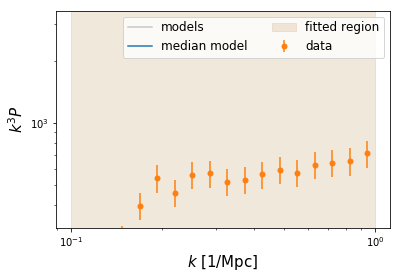

In [26]:
plt.fill_between([0.1, 1.0], 1e2, 1e4, color='tan', alpha=0.3, label="fitted region")

label="models"
every=1
for pp in model_power[::every]:
    plt.plot(k, pp*k**3, color='k', alpha=0.2, label=label, zorder=1)
    if label:
        label=None

mean = np.mean(model_power*k**3, axis=0)
std = np.std(model_power*k**3, axis=0)
md = np.median(model_power*k**3, axis=0)


plt.fill_between(k, mean - std, mean+std, color="C0", alpha=0.6)
plt.plot(k, md, color="C0", label="median model")

plt.errorbar(k, data[0]*k**3, yerr = (0.15*data[0]*k**3), color="C1", 
             label="data", ls="None", markersize=5, marker='o')
                 

plt.legend(ncol=2, fontsize=12)
plt.ylim((3.1e2, 3.5e3))

plt.xlabel("$k$ [1/Mpc]", fontsize=15)
plt.ylabel("$k^3 P$", fontsize=15)
plt.xscale('log')
plt.yscale('log')

#plt.savefig(join(direc, modelname+"_power_spectrum_plot.pdf"))

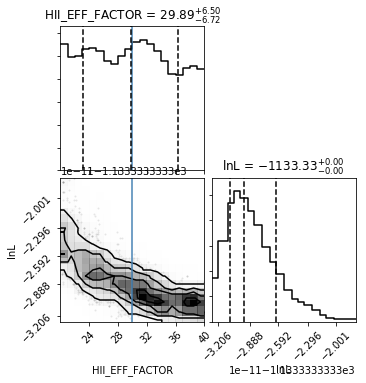

In [41]:
INCLUDE_LNL = True
truths = [chain.params[0][0]]

if INCLUDE_LNL:
    plotchain = np.vstack((_chain.T,np.atleast_3d(lnprob).T)).T.reshape((-1, nparams+1))
    truths += [None]
    labels = chain.params.keys + ['lnL']
else:
    plotchain = _chain.reshape((-1, nparams))
    labels = chain.params.keys
    
corner(
    plotchain, 
    labels=labels, 
    truths=truths,
    smooth=0.75,
    smooth1d=1.0,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84]
);


In [34]:
chain.params[0]

array([30., 20., 40.,  3.])